In [1]:
import pandas as pd
from fastai.collab import *
from sklearn.neighbors import NearestNeighbors
import json

In [2]:
drop_column_fields = ['best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year','average_rating', 'ratings_1', 'ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url', 'language_code', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count']
books = pd.read_csv("books.csv").drop(columns = drop_column_fields)

reviews = pd.read_csv('ratings.csv')

In [3]:
books

,id,book_id,original_title,title
0,1,2767052,The Hunger Games,"The Hunger Games (The Hunger Games, #1)"
1,2,3,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,41865,Twilight,"Twilight (Twilight, #1)"
3,4,2657,To Kill a Mockingbird,To Kill a Mockingbird
4,5,4671,The Great Gatsby,The Great Gatsby
...,...,...,...,...
9995,9996,7130616,Bayou Moon,"Bayou Moon (The Edge, #2)"
9996,9997,208324,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)"
9997,9998,77431,The Mauritius Command,The Mauritius Command
9998,9999,8565083,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...


In [4]:
data = CollabDataBunch.from_df(reviews, user_name='user_id', item_name='book_id', rating_name='rating', seed=42)


In [5]:
### Embedded Dot Bias Model
def createDotBiasLearner(data, n_weights = 50, y_range=None):
    learner = collab_learner(data, n_factors=n_weights, y_range=y_range)
    print(learner.summary())
    return learner

def plotLearningRateVsLoss(learner):
    lr_find(learner)
    learner.recorder.plot()

learner = createDotBiasLearner(data, n_weights=50, y_range=(1.,5))

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [50]                 2,652,900  True      
______________________________________________________________________
Embedding            [50]                 500,050    True      
______________________________________________________________________
Embedding            [1]                  53,058     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 3,216,009
Total trainable params: 3,216,009
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



In [6]:
# Find a good learning rate
lr_find(learner)
# learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


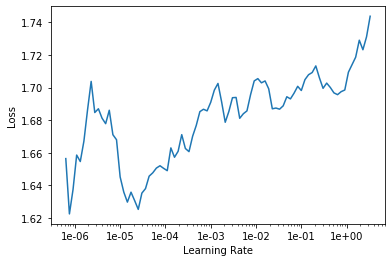

In [7]:
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(10, 1.1e-5, wd=0.10)

epoch,train_loss,valid_loss,time
0,1.708257,1.696666,01:44
1,1.671381,1.689993,01:41
2,1.671635,1.678623,01:41
3,1.667460,1.666803,01:42
4,1.674469,1.656420,01:44
5,1.628426,1.648210,01:45
6,1.660512,1.642516,01:41
7,1.641675,1.639271,01:39
8,1.641185,1.637984,01:41
9,1.652255,1.637796,01:46


In [31]:
# Save the model
# learner.save("trained_model", return_path=True)
# learner.load("trained_model");
learner

CollabLearner(data=TabularDataBunch;

Train: LabelList (785405 items)
x: CollabList
user_id 439; book_id 1; ,user_id 588; book_id 1; ,user_id 1169; book_id 1; ,user_id 1185; book_id 1; ,user_id 2077; book_id 1; 
y: FloatList
3.0,5.0,4.0,4.0,4.0
Path: .;

Valid: LabelList (196351 items)
x: CollabList
user_id 19643; book_id 6495; ,user_id 8563; book_id 6175; ,user_id 52110; book_id 9920; ,user_id 33864; book_id 215; ,user_id 16587; book_id 2728; 
y: FloatList
5.0,4.0,3.0,5.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(53058, 50)
  (i_weight): Embedding(10001, 50)
  (u_bias): Embedding(53058, 1)
  (i_bias): Embedding(10001, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=WindowsPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=

### Finding Similar Books

In [13]:
# Group the reviews by book, get the rating column and aggregate each group by with its mean and count
book_by_all_users = reviews.groupby('book_id')['rating'].agg(['mean','count'])
# book_by_all_users.sort_values('mean',ascending=False, inplace=True)
book_indexes = book_by_all_users.index

g = reviews.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:10000]
top_books = top_books.astype(str)

# # All Book Bias
all_book_bias = learner.bias(top_books, is_item=True)
book_weights = learner.weight(top_books, is_item=True)
book_pca = book_weights.pca(4)
book_np_weights = book_pca.numpy()

# learner.predict([1])
top_books

array(['5000', '3315', '3313', '3312', ..., '1935', '9486', '9345', '7803'], dtype='<U21')

In [21]:
nn = NearestNeighbors(n_neighbors=len(book_indexes))
fitnn = nn.fit(book_np_weights)
distance, neighbours = fitnn.kneighbors(X=[book_np_weights[1]], n_neighbors=10)

In [22]:
def getRecommendations( book, n_recommendations):
    distance, neighbours = fitnn.kneighbors(X=[book_np_weights[book]], n_neighbors=n_recommendations + 1)
    recommend_list=[]
    for i,value in enumerate(neighbours, start=0):
        recommend_list.append(book_indexes[value])
    return recommend_list[0].to_list()

In [23]:
getRecommendations(1, 10)

[2, 7265, 692, 3115, 1169, 6771, 2688, 4357, 8886, 6508, 4037]

In [26]:
books.loc[getRecommendations(1, 40)]

,id,book_id,original_title,title
2,3,41865,Twilight,"Twilight (Twilight, #1)"
7265,7266,6671,The Wonderful Story Of Henry Sugar And Six More,The Wonderful Story of Henry Sugar and Six More
692,693,455373,Sphere,Sphere
3115,3116,10345927,A Million Suns,"A Million Suns (Across the Universe, #2)"
1169,1170,13104080,"Unravel Me (Shatter Me, #2)","Unravel Me (Shatter Me, #2)"
6771,6772,716696,رباعیات [Robāʿiāt-e ʿOmar Khayyām],رباعيات خيام
2688,2689,815234,The Napping House,The Napping House
4357,4358,6413193,Nine Dragons,"Nine Dragons (Harry Bosch, #15; Mickey Haller,..."
8886,8887,15810910,The Thousand Names,"The Thousand Names (The Shadow Campaigns, #1)"
6508,6509,63432,3001: The Final Odyssey,"3001: The Final Odyssey (Space Odyssey, #4)"


In [27]:
def exportRecommendationList( output_file, indexes, num_recommendations ):
    book_map = {}
    
    for i in range(len(indexes)):
        result = getRecommendations( i , num_recommendations )
        book_map[result[0]] = result[1:]
        
    with open( output_file, 'w') as fp:
        json.dump(book_map, fp)
        
    return book_map
book_map = exportRecommendationList( "recommendations2.json" , top_books, 40 )

Fast AI Collaborative Filtering

https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson4-collab.ipynb

Medium Article

https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0 

https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00